## Understanding the Data

Before performing any processing on the available data, exploratory data analysis is recommended. This process includes visualization of the data for better understanding, identifying the outliers, and skewed predictors.

In [1]:
#Data Manipulation

import numpy as np

import pandas as pd

# Visualization

import matplotlib.pyplot as plt

import seaborn as sns

import keras

from keras.preprocessing.text import Tokenizer

from keras.models import Sequential

from keras.layers import Dense

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten,Conv1D, MaxPooling1D

from keras.models import Model

from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

from keras import layers

#NLP for text pre-processing

import nltk

from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

# for spliting data set and metrics

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

#Handling imbalance data

from imblearn.over_sampling import SMOTE

# Plot the Figures Inline

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Let's import the data and understand the columns.

# Loading the dataset

Prod_cat_data = pd.read_csv('/content/drive/MyDrive/flipkart_com-ecommerce.csv')

Prod_cat_data.shape

(20000, 15)

In [4]:
Prod_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

The e-commerce data set has 15 attributes; out of these columns, we only extracted the following elements for further analysis: description and product_category_tree.

The remaining columns are not considered for building the text classification model. So, only the description column is considered useful.

## Exploratory Data Analysis

Before moving ahead, let's look at the distribution of each category.

In [5]:
import pandas as pd

# Assuming your DataFrame is named Prod_cat_data

# Split the product_category_tree column by ">>" and extract the first level category
Prod_cat_data['product_category'] = Prod_cat_data['product_category_tree'].apply(lambda x: x.split('>>')[0].strip())

# Get the frequency count of each category
category_counts = Prod_cat_data['product_category'].value_counts()

# Remove the leading characters from the category names
category_counts.index = category_counts.index.str[2:]

# Display the top 20 categories
categories = category_counts.head(20)
print(categories)

Clothing                      6198
Jewellery                     3531
Footwear                      1227
Mobiles & Accessories         1099
Automotive                    1012
Home Decor & Festive Needs     929
Beauty and Personal Care       710
Home Furnishing                700
Kitchen & Dining               647
Computers                      578
Watches                        530
Baby Care                      483
Tools & Hardware               391
Toys & School Supplies         330
Pens & Stationery              313
Bags, Wallets & Belts          265
Furniture                      180
Sports & Fitness               166
Cameras & Accessories           82
Home Improvement                81
Name: product_category, dtype: int64


<Axes: title={'center': 'Product Category Distribution'}>

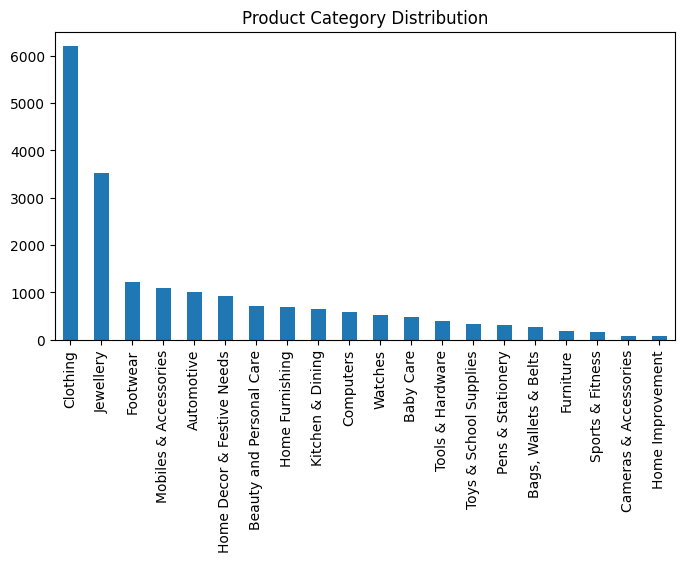

In [6]:
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
categories.plot(ax=ax, kind='bar', title='Product Category Distribution')

## Data Preprocessing

In this program, we are bound to do certain data preprocessing steps, including data cleaning, preparation, transformation, and dimensionality reduction.

First, we investigate the usual data set level cleaning and then later jump into text preprocessing.

Let's see if there are any missing values in the description column.

In [7]:
# Number of missing values in each column

missing = pd.DataFrame (Prod_cat_data.isnull().sum()).rename (columns = {0: 'missing' })

# Create a percentage of missing values

missing['percent'] = missing['missing'] / len(Prod_cat_data)

# sorting the values in descending order to see highest count on the top

missing.sort_values ('percent', ascending = False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
description,2,0.00010
uniq_id,0,0.00000
crawl_timestamp,0,0.00000
product_url,0,0.00000
product_name,0,0.00000


In [8]:
# Removing missing values in description

Prod_cat_data=Prod_cat_data[pd.notnull(Prod_cat_data['description'])]

Text(0.5, 1.0, 'Word distribution per bin')

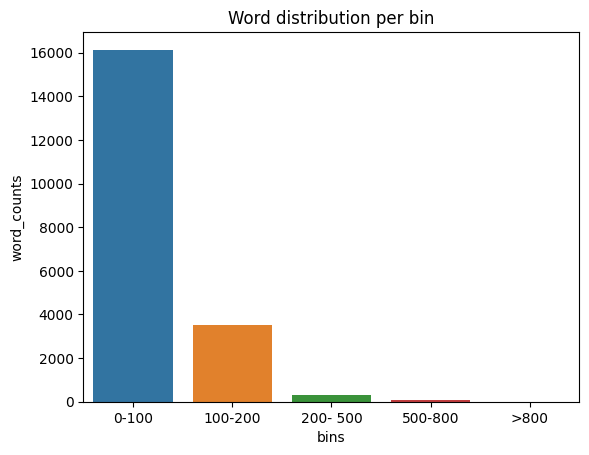

In [9]:
Prod_cat_data['no_of_words'] = Prod_cat_data.description.apply(lambda a :len(a.split()))

bins=[0,50,75, np.inf]

Prod_cat_data['bins' ]=pd. cut (Prod_cat_data.no_of_words, bins=[0, 100, 300, 500, 800, np. inf], labels=['0-100', '100-200', '200- 500', '500-800','>800'])

words_distribution = Prod_cat_data.groupby('bins').size().reset_index().rename (columns={0: 'word_counts'})

sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")

## Text Preprocessing

We already observed the value that text preprocessing lends to many text-related tasks. Let's jump into implementation.

The following is data before text preprocessing.

In [10]:
Prod_cat_data['description'][8]

'Key Features of dilli bazaaar Bellies, Corporate Casuals, Casuals Material: Fabric Occasion: Ethnic, Casual, Party, Formal Color: Pink Heel Height: 0,Specifications of dilli bazaaar Bellies, Corporate Casuals, Casuals General Occasion Ethnic, Casual, Party, Formal Ideal For Women Shoe Details Weight 200 g (per single Shoe) - Weight of the product may vary depending on size. Heel Height 0 inch Outer Material Fabric Color Pink'

In [11]:
# Remove punctuation

Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space

Prod_cat_data['description'] = Prod_cat_data['description'] .str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace

Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'^\s+ |\s+?$', '')

# converting to lower case

Prod_cat_data['description'] = Prod_cat_data['description'].str.lower()

# Replace numbers like price values with 'numbr'

Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\d+(\.\d+)?', 'numbr')

Prod_cat_data['description'][8]

<ipython-input-11-163c645671e9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'[^\w\d\s]', ' ')
<ipython-input-11-163c645671e9>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'] .str.replace(r'\s+', ' ')
<ipython-input-11-163c645671e9>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'^\s+ |\s+?$', '')
<ipython-input-11-163c645671e9>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\d+(\.\d+)?', 'numbr')


'key features of dilli bazaaar bellies corporate casuals casuals material fabric occasion ethnic casual party formal color pink heel height numbr specifications of dilli bazaaar bellies corporate casuals casuals general occasion ethnic casual party formal ideal for women shoe details weight numbr g per single shoe weight of the product may vary depending on size heel height numbr inch outer material fabric color pink'

The stop words are imported from the NLTK library and are removed from the description. There are two kinds of stop words.

* General stop words like an and in appear everywhere irrespective of the domain. It doesn't matter where the text is coming from.

* There are few domain-specific stop words. For example, buy, com, and cash can appear only in certain domains, such as e-commerce and retail. We need to remove them as well.

In [12]:
# Removing Stopwords

import nltk
nltk.download('stopwords')

stop = stopwords.words ('english')

pattern = r'\b(?:{})\b'.format('|'.join(stop))

Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(pattern, '')

Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\s+',' ') # Removing single characters

Prod_cat_data['description'] = Prod_cat_data['description'].apply(lambda a: " ".join(a for a in a.split() if len(a)>1))

Prod_cat_data['description'][8]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-12-80bec10e27ee>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(pattern, '')
<ipython-input-12-80bec10e27ee>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  Prod_cat_data['description'] = Prod_cat_data['description'].str.replace(r'\s+',' ') # Removing single characters


'key features dilli bazaaar bellies corporate casuals casuals material fabric occasion ethnic casual party formal color pink heel height numbr specifications dilli bazaaar bellies corporate casuals casuals general occasion ethnic casual party formal ideal women shoe details weight numbr per single shoe weight product may vary depending size heel height numbr inch outer material fabric color pink'

Let's plot word cloud on descriptions to get to know the words that are appearing the greatest number of times.

In [13]:
wordcloud = WordCloud (background_color="white", width = 800, height = 400).generate(' '.join(Prod_cat_data['description']))

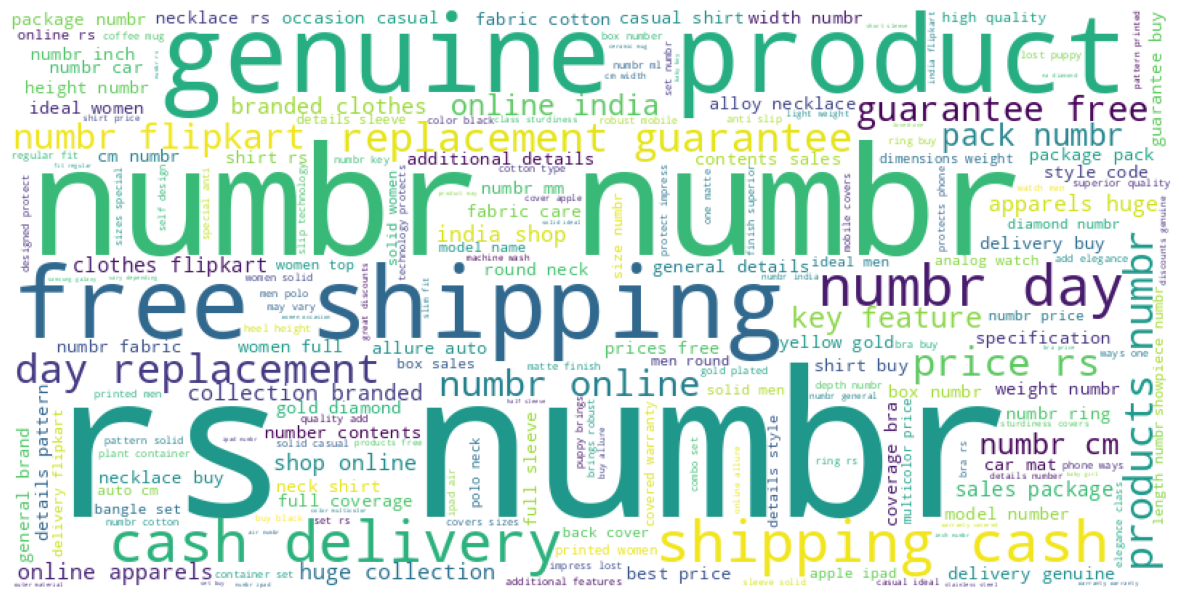

In [14]:
plt.figure(figsize=(15,8))

plt.imshow(wordcloud)

plt.axis("off")

plt.show()

There are a lot of domain-related words occurring in the corpus, which add no value to the task. For example, the word rs is an Indian currency present in most documents but not useful. Let's remove these domain-related stop words and plot again.

In [15]:
# Removing domain-related stop words from the description

specific_stop_words = ["numbr", "rs", "flipkart", "buy", "com", "free","day", "cash", "replacement", "guarantee", "genuine", "key", "feature", "delivery","products", "product", "shipping", "online", "india", "shop"]

Prod_cat_data['description'] = Prod_cat_data['description'].apply(lambda a: " ".join(a for a in a.split() if a not in specific_stop_words))

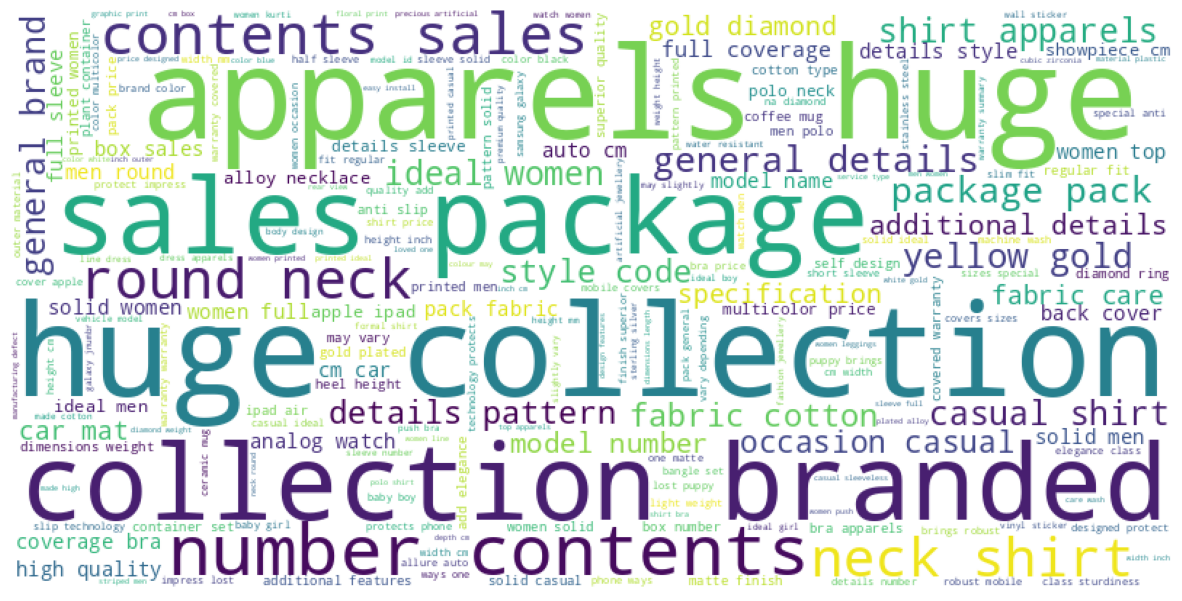

In [16]:
wordcloud  = WordCloud (background_color="white", width = 800, height = 400).generate(''.join(Prod_cat_data['description']))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)

plt.axis("off")

plt.show()


Note that there are words related to the product categories. Once the data is cleaned, we can proceed with the feature engineering.

## Feature Engineering

To build the text classification model, we need to first convert the text data into features.

We use deep learning algorithms to build the classifier, and feature extraction should be carried out accordingly. We use the Keras tokenizer function to generate features. We are setting max_length to 200, which means we are only considering 200 features for the classifier. This number also decides the accuracy, and the ideal number can be obtained from hyperparameter tuning.

In [17]:
MAX_LENGTH= 200

prod_tok = Tokenizer()

prod_tok.fit_on_texts (Prod_cat_data['description'])

clean_description = prod_tok.texts_to_sequences (Prod_cat_data['description'])

#padding

X = pad_sequences(clean_description, maxlen = MAX_LENGTH)

Like features, we need to also convert the target variable. We use label encoding to do so. The function used is LabelEncoder from sklearn.

## Train-Test Split

The data is split into two parts: one for training the model and one for evaluating the model.

The train_test_split library from sklearn.model_selection is imported to split the data frame.

In [18]:
# Label encoder for Target variable

from sklearn.preprocessing import LabelEncoder

num_class = len (np.unique (Prod_cat_data.product_category_tree.values))

y = Prod_cat_data['product_category_tree'].values

encoder = LabelEncoder()

encoder.fit(y)

y = encoder.transform(y)

In [19]:
#train test split

from sklearn.model_selection import train_test_split

indepentent_features_build, indepentent_features_valid, depentent_feature_build, depentent_feature_valid = train_test_split(X, y, test_size=0.2, random_state=1) #train 80, test 20
print (indepentent_features_build.shape)
print(indepentent_features_valid.shape)
print(depentent_feature_build.shape)
print(depentent_feature_valid.shape)

(15998, 200)
(4000, 200)
(15998,)
(4000,)


## Model Building

The following list of classifiers is used for creating various classification models, which can be further used for prediction.

* Simple baseline artificial neural networks (ANNs)

* Recurrent neural networks (RNN-LSTM)

* Convolutional neural networks

## ANN

Let's start with the basic neural network using imbalanced data.

The following is the architecture for the neural network. The input neurons are the max_length defined earlier. Then there is an embedding or hidden layer with a linear activation function by default, but we can also use ReLU. In the end, there is a softmax layer with 14 neurons since there are 14 categories. We are using rmsprop optimizer with categorical cross-entropy as a loss function.

In [20]:
model_inp = Input(shape=(MAX_LENGTH,))

vocab_size = len(prod_tok.word_index) + 1  # Adding 1 for the unknown token (index 0)

object_layer = Embedding(vocab_size, 100, input_length=MAX_LENGTH)(model_inp)

a = Flatten()(object_layer)
a = Dense(30)(a)

# Default activation function is linear, we can make use of relu.

model_pred = Dense(num_class, activation='softmax')(a)

output = Model(inputs=[model_inp], outputs=model_pred)

output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

output.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          2081800   
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 30)                600030    
                                                                 
 dense_1 (Dense)             (None, 6466)              200446    
                                                                 
Total params: 2,882,276
Trainable params: 2,882,276
Non-trainable params: 0
_________________________________________________________________


In [21]:
filepath="output_ANN.hdf5"

X = ModelCheckpoint (filepath, monitor= 'val_acc', verbose=1, save_best_only=True, mode='max')

#fit the model

out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical (depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

#predict

output_pred = output.predict(indepentent_features_valid)

output_pred = np.argmax(output_pred, axis=1)

accuracy_score = (depentent_feature_valid, output_pred)

Epoch 1/50
187/188 [============================>.] - ETA: 0s - loss: 7.0071 - acc: 0.0864
Epoch 1: val_acc improved from -inf to 0.11725, saving model to output_ANN.hdf5
188/188 [==============================] - 11s 52ms/step - loss: 7.0041 - acc: 0.0867 - val_loss: 6.5419 - val_acc: 0.1173
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 6.0209 - acc: 0.1722
Epoch 2: val_acc improved from 0.11725 to 0.21550, saving model to output_ANN.hdf5
188/188 [==============================] - 8s 40ms/step - loss: 6.0209 - acc: 0.1722 - val_loss: 5.9178 - val_acc: 0.2155
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 5.4745 - acc: 0.2476
Epoch 3: val_acc improved from 0.21550 to 0.24625, saving model to output_ANN.hdf5
188/188 [==============================] - 11s 60ms/step - loss: 5.4745 - acc: 0.2476 - val_loss: 5.5646 - val_acc: 0.2463
Epoch 4/50
187/188 [============================>.] - ETA: 0s - loss: 5.1488 - acc: 0.3009
Epoch 4: val_acc impro

## Long Short-Term Memory: Recurrent Neural Networks

We tried out normal neural networks which don't capture the sequence of the data. Let's try a long short-term memory network where the sequence is also captured while training the model. This is best suited for text since text data is sequential.

The following is the architecture for the neural network. The input neurons are the max_length we defined earlier. An LSTM layer follows an embedding layer. In the end, there is a softmax layer with 14 neurons. We are using a rmsprop optimizer with categorical cross-entropy as a loss function.

In [23]:
model_inp  = Input (shape=(MAX_LENGTH, ))

#define embedding layer

object_layer = Embedding (vocab_size, 100, input_length=MAX_LENGTH) (model_inp)

#add LSTM layer

a = LSTM(60) (object_layer)

#add dense layer

a = Dense (30)(a) #default activation function is linear, we can make use of relu.

#final

model_pred = Dense (num_class, activation='softmax')(a)

output = Model(inputs = [model_inp], outputs=model_pred)

#compile

output.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

output.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          2081800   
                                                                 
 lstm (LSTM)                 (None, 60)                38640     
                                                                 
 dense_2 (Dense)             (None, 30)                1830      
                                                                 
 dense_3 (Dense)             (None, 6466)              200446    
                                                                 
Total params: 2,322,716
Trainable params: 2,322,716
Non-trainable params: 0
_________________________________________________________________


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score

filepath="output_LSTM.hdf5"

#model checkpoint

X = ModelCheckpoint (filepath, monitor = 'val_acc', verbose=1, save_best_only=True, mode='max')

#fitting

out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

output.load_weights ('output_LSTM.hdf5')

#predicting on validation data

output_pred = output.predict(indepentent_features_valid)

output_pred = np.argmax (output_pred, axis=1)

#score

accuracy_score (depentent_feature_valid, output_pred)

Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 5.4914 - acc: 0.2299
Epoch 1: val_acc improved from -inf to 0.22325, saving model to output_LSTM.hdf5
188/188 [==============================] - 48s 256ms/step - loss: 5.4914 - acc: 0.2299 - val_loss: 5.6583 - val_acc: 0.2233
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 5.3685 - acc: 0.2487
Epoch 2: val_acc improved from 0.22325 to 0.23700, saving model to output_LSTM.hdf5
188/188 [==============================] - 50s 265ms/step - loss: 5.3685 - acc: 0.2487 - val_loss: 5.5533 - val_acc: 0.2370
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 5.2406 - acc: 0.2750
Epoch 3: val_acc improved from 0.23700 to 0.27650, saving model to output_LSTM.hdf5
188/188 [==============================] - 50s 267ms/step - loss: 5.2406 - acc: 0.2750 - val_loss: 5.4385 - val_acc: 0.2765
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 5.0842 - acc: 0.3063
Epoch 4: val_ac

0.4975

Text(0, 0.5, 'Validation Accuracy')

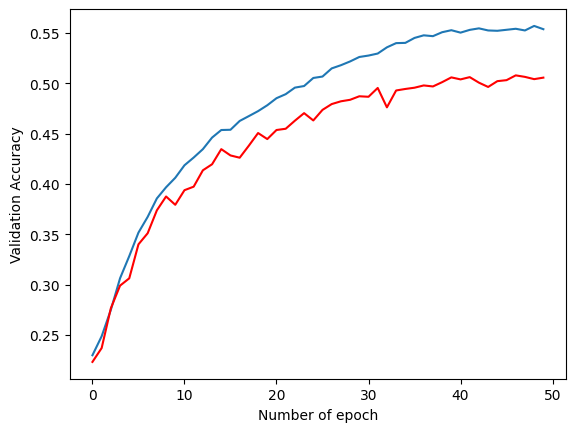

In [26]:
dfaccuracy = pd.DataFrame({'Number of epoch': out.epoch, 'Model hist': out.history['acc'], 'Model Perd': out.history['val_acc']})

# Line for train accuracy
g = sns.lineplot(x="Number of epoch", y="Model hist", data=dfaccuracy)

# Line for test accuracy
g = sns.lineplot(x="Number of epoch", y="Model Perd", data=dfaccuracy, color='red')

# Set y-axis label
g.set_ylabel('Validation Accuracy')

## Convolutional Neural Networks

These types of networks are mainly used for image processing. But recent trends show that CNN is performing well on text data if the right parameters are used. Let's see how well it performs in this case.

The following is the architecture for the neural network. The input neurons are the max_length defined earlier. Everything remains the same. Just as there is are convolution and max-pooling layers between an embedding layer and LSTM layer, there is a softmax layer with 14 neurons. We are using a rmsprop optimizer with categorical cross-entropy as a loss function.

In [27]:
model_inp = Input (shape=(MAX_LENGTH, ))

# define the layer

object_layer = Embedding (vocab_size, 100, input_length=MAX_LENGTH) (model_inp)

#conv layer

a = Conv1D(60, 10) (object_layer) #default activation function is linear, we can make use of relu.

#add pooling layer

a = MaxPooling1D (pool_size=2) (a)

#add LSTM

a = LSTM(60)(a)

a = Dense (30)(a)

#final layer

model_pred = Dense (num_class, activation='softmax')(a)

output = Model (inputs = [model_inp], outputs=model_pred)

#compile

output.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['acc'])

output.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          2081800   
                                                                 
 conv1d (Conv1D)             (None, 191, 60)           60060     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 95, 60)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                           

In [28]:
filepath="output_CNN.hdf5"

X = ModelCheckpoint (filepath, monitor= 'val_acc', verbose=1, save_best_only=True, mode='max')

out = output.fit([indepentent_features_build], batch_size=64, y=to_categorical (depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, epochs=50, callbacks=[X])

output.load_weights ('output_CNN.hdf5')

predicted = output.predict(indepentent_features_valid)

predicted = np.argmax (predicted, axis=1)
accuracy_score (depentent_feature_valid, predicted)

Epoch 1/50
188/188 [==============================] - ETA: 0s - loss: 7.0347 - acc: 0.0808
Epoch 1: val_acc improved from -inf to 0.08025, saving model to output_CNN.hdf5
188/188 [==============================] - 97s 305ms/step - loss: 7.0347 - acc: 0.0808 - val_loss: 6.5791 - val_acc: 0.0803
Epoch 2/50
188/188 [==============================] - ETA: 0s - loss: 6.3293 - acc: 0.0858
Epoch 2: val_acc improved from 0.08025 to 0.09725, saving model to output_CNN.hdf5
188/188 [==============================] - 54s 288ms/step - loss: 6.3293 - acc: 0.0858 - val_loss: 6.3143 - val_acc: 0.0972
Epoch 3/50
188/188 [==============================] - ETA: 0s - loss: 6.0155 - acc: 0.1167
Epoch 3: val_acc improved from 0.09725 to 0.14375, saving model to output_CNN.hdf5
188/188 [==============================] - 59s 317ms/step - loss: 6.0155 - acc: 0.1167 - val_loss: 6.0474 - val_acc: 0.1437
Epoch 4/50
188/188 [==============================] - ETA: 0s - loss: 5.6769 - acc: 0.1894
Epoch 4: val_acc i

0.50725

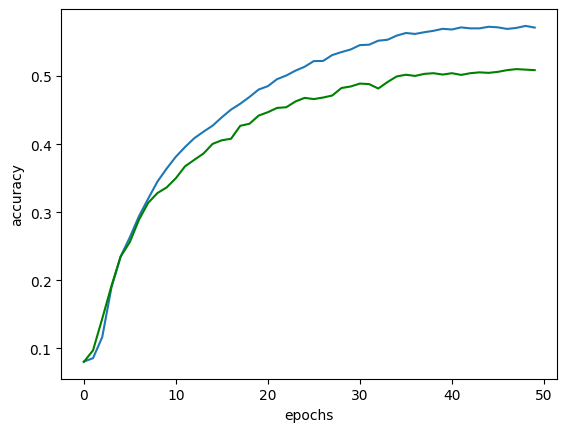

In [29]:
dfaccuracy = pd.DataFrame({'epochs': out. epoch, 'accuracy': out. history['acc'], 'validation_accuracy': out. history['val_acc']})
# Line for train accuracy
g = sns.lineplot(x="epochs", y="accuracy", data=dfaccuracy)

# Line for test accuracy
g = sns.lineplot(x="epochs", y="validation_accuracy", data=dfaccuracy, color='green')